In [1]:
import warnings
warnings.filterwarnings('ignore')

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import pearsonr

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

/home/fergus/miniconda3/envs/the-lig/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor']='w'
#plt.rcParams['axes.linewidth']=1
plt.rcParams['axes.edgecolor']='w'
plt.rcParams['figure.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
#plt.rcParams['grid.color']='white'

Load data - we use PDBbind 2018 general to compute feature importance.

In [3]:
rdkit_features = pd.read_csv(pathlib.Path('..', 'data', 'pdbbind_2018_general_rdkit_features_clean.csv'), index_col=0)
rfscore_features = pd.read_csv(pathlib.Path('..', 'data', 'pdbbind_2018_general_rfscore_features_clean.csv'), index_col=0)
nnscore_features = pd.read_csv(pathlib.Path('..', 'data', 'pdbbind_2018_general_binana_features_clean.csv'), index_col=0)
binding_data = pd.read_csv(pathlib.Path('..', 'data', 'pdbbind_2018_general_binding_data_clean.csv'), index_col=0, squeeze=True)
binding_data = binding_data.rename('pK')

# re-label RF-Score features to use element symbol instead of atomic number
element_symbol = {
    6: 'C',
    7: 'N',
    8: 'O',
    9: 'F',
    15: 'P',
    16: 'S',
    17: 'Cl',
    35: 'Br',
    53: 'I'
}
mapper = lambda f: element_symbol[int(f.split('.')[0])] + '-' + element_symbol[int(f.split('.')[1])]
rfscore_features = rfscore_features.rename(mapper=mapper, axis='columns')

all_features = pd.concat([rdkit_features, rfscore_features, nnscore_features], axis='columns')

feature_sets = {
    'Vina': pd.Index(['vina_gauss1', 'vina_gauss2', 'vina_hydrogen', 'vina_hydrophobic', 'vina_repulsion', 'num_rotors']),
    'RDKit': rdkit_features.columns,
    'RF-Score': rfscore_features.columns,
    'NNScore 2.0': nnscore_features.columns,
}

feature_sets['RF-Score v3'] = feature_sets['RF-Score'].union(feature_sets['Vina'])

for f in ['Vina', 'RF-Score', 'RF-Score v3', 'NNScore 2.0']:
    feature_sets[f'{f} + RDKit'] = feature_sets[f].union(feature_sets['RDKit'])
    # Vina, and hence anything that includes its terms, already uses the number of rotatable bonds, so we drop the RDKit version
    if f != 'RF-Score':
        feature_sets[f'{f} + RDKit'] = feature_sets[f'{f} + RDKit'].drop(['NumRotatableBonds'])

core_sets = {}
for year in ['2007', '2013', '2016']:
    with open(pathlib.Path('..', 'data', f'pdbbind_{year}_core_pdbs.txt')) as f:
        core_sets[year] = sorted([l.strip() for l in f])
core_sets['all'] = [pdb for pdb in core_sets['2007']]
core_sets['all'] = core_sets['all'] + [pdb for pdb in core_sets['2013'] if pdb not in core_sets['all']]
core_sets['all'] = core_sets['all'] + [pdb for pdb in core_sets['2016'] if pdb not in core_sets['all']]

test_sets = {c: pd.Index(core_sets[c]).intersection(all_features.index) for c in core_sets}

test = pd.Index(core_sets['all'])
train = all_features.index.difference(test)

Fit RFs and record feature importance.

In [5]:
feature_importance = {}
relative_importance = {}

oob_score = {}

for f in feature_sets:
    features = feature_sets[f]
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=64, oob_score=True)
    X_train = all_features.loc[train, features]
    y_train = binding_data.loc[train]
    rf.fit(X_train, y_train)
    feature_importance[f] = rf.feature_importances_
    oob_score[f] = pearsonr(y_train.values.ravel(), rf.oob_prediction_)[0]
    
    feature_importance[f] = pd.Series(data=feature_importance[f], index=features)
    feature_importance[f] = feature_importance[f].sort_values(ascending=False)
    relative_importance[f] = feature_importance[f] / feature_importance[f].max()

Plot relative feature importances.

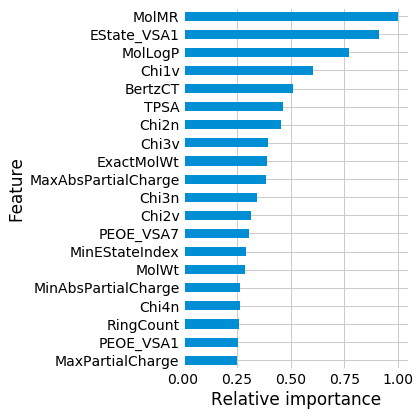

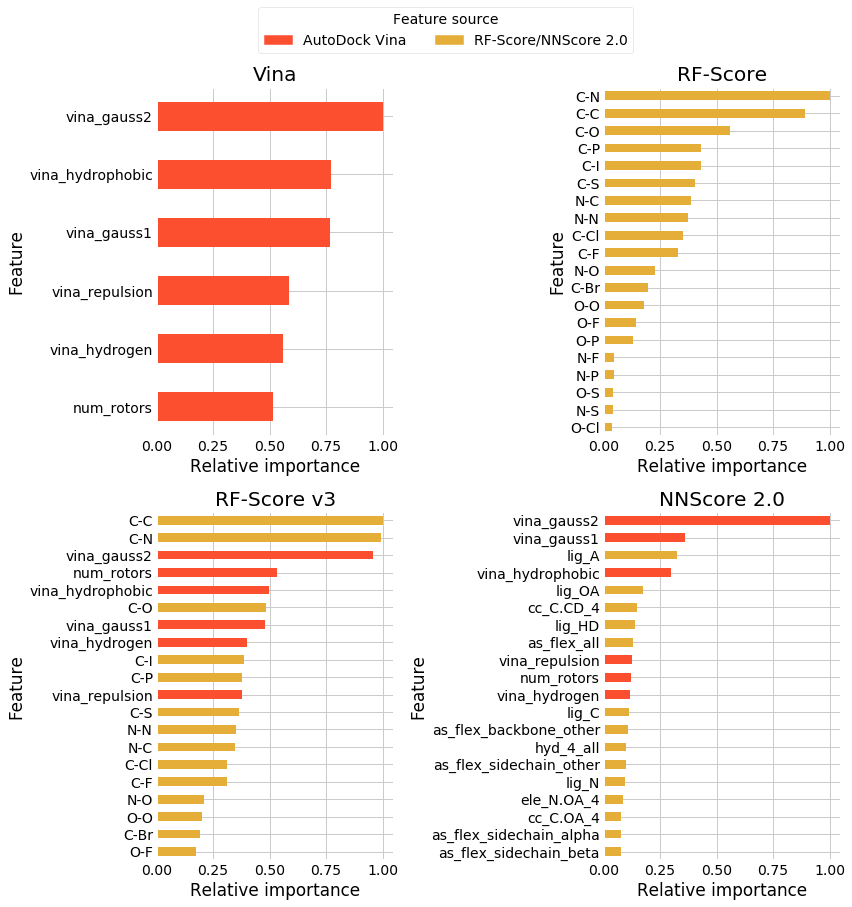

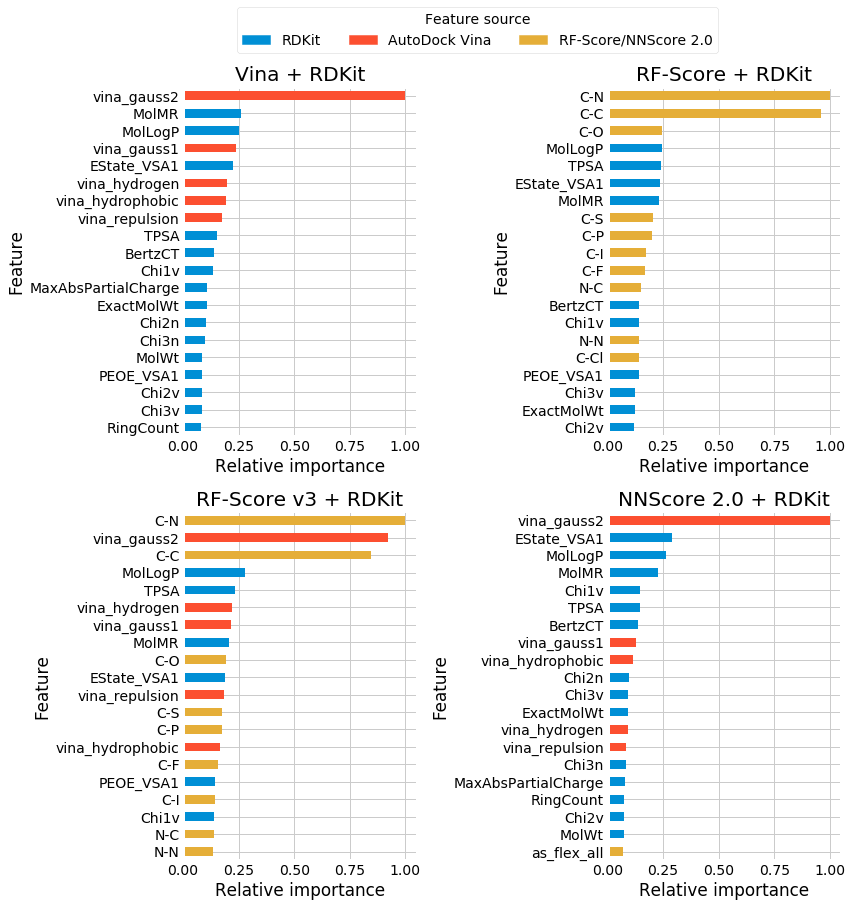

In [6]:
import matplotlib.patches as mpatches

colours = plt.rcParams['axes.prop_cycle'].by_key()['color'][:3]
cmap = {f: colours[0] for f in feature_sets['RDKit']}
for f in feature_sets['RF-Score']:
    cmap[f] = colours[2]
for f in feature_sets['NNScore 2.0']:
    cmap[f] = colours[2]
for f in feature_sets['Vina']:
    cmap[f] = colours[1]
labels = ['RDKit', 'AutoDock Vina', 'RF-Score/NNScore 2.0']
handles = [mpatches.Patch(color=c, label=l) for c, l in zip(colours, labels)]

to_plot = relative_importance['RDKit'].iloc[:20]
fig, ax = plt.subplots(1,1,figsize=(6,6))
bar_colours = [cmap[l] for l in to_plot.index]
to_plot.plot(
    kind='barh',
    color=bar_colours,
    ax=ax
)
ax.invert_yaxis()
ax.set_ylabel('Feature')
ax.set_xlabel('Relative importance')
fig.tight_layout()
fig.show()
fig.savefig(pathlib.Path('..', 'figures', 'feature_importance_rdkit.jpg'), dpi=350, bbox_inches='tight')

fig, axes = plt.subplots(2,2,figsize=(12,12))
for f, ax in zip(['Vina', 'RF-Score', 'RF-Score v3', 'NNScore 2.0'], axes.flatten()):
    to_plot = relative_importance[f].iloc[:20]
    bar_colours = [cmap[l] for l in to_plot.index]
    to_plot.plot(
        kind='barh',
        color=bar_colours,
        ax=ax
    )
    ax.invert_yaxis()
    ax.set_title(f)
    ax.set_ylabel('Feature')
    ax.set_xlabel('Relative importance')
fig.tight_layout()
axes[0][0].legend(handles[1:], labels[1:], title='Feature source', loc='upper left', bbox_to_anchor=(0.4, 1.25),ncol=3)
fig.show()
fig.savefig(pathlib.Path('..', 'figures', 'feature_importance_sb_sfs.jpg'), dpi=350, bbox_inches='tight')

fig, axes = plt.subplots(2,2,figsize=(12,12))
for f, ax in zip(['Vina + RDKit', 'RF-Score + RDKit', 'RF-Score v3 + RDKit', 'NNScore 2.0 + RDKit'], axes.flatten()):
    to_plot = relative_importance[f].iloc[:20]
    bar_colours = [cmap[l] for l in to_plot.index]
    to_plot.plot(
        kind='barh',
        color=bar_colours,
        ax=ax
    )
    ax.invert_yaxis()
    ax.set_title(f)
    ax.set_ylabel('Feature')
    ax.set_xlabel('Relative importance')
fig.tight_layout()
axes[0][0].legend(handles, labels, title='Feature source', loc='upper left', bbox_to_anchor=(0.2, 1.25),ncol=3)
fig.show()
fig.savefig(pathlib.Path('..', 'figures', 'feature_importance_augmented_sf.jpg'), dpi=350, bbox_inches='tight')